In [1]:
# Importación de librerias.
import pandas as pd
from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt

# Carga del dataset. 
analogias_df = pd.read_csv('analogies_answers.csv')
analogias_df.head()

,cueEjemplo,targetEjemplo,cue,response,count,rank,porcentaje
0,Argentina,Buenos Aires,Brasil,brasilia,87.0,1.0,90.625000
1,Brasil,samba,Cuba,salsa,57.0,1.0,60.000000
2,Francia,París,Estados Unidos,washington,92.0,1.0,49.729730
3,París,Francia,Roma,italia,77.0,1.0,93.902439
4,China,Asia,Rusia,eurasia,38.0,1.0,37.254902


In [5]:
# Embeddings utilizados.
embeddings_WIKI = KeyedVectors.load_word2vec_format('embeddings/wiki.es.vec', limit=None)
embeddings_SUC = KeyedVectors.load_word2vec_format('embeddings/embeddings-l-model.vec', limit=None)
embeddings_SWOW = KeyedVectors.load_word2vec_format('embeddings/swow.embedding.was.26-04-2022.vec', limit=None)
lower_embeddings_SWOW = KeyedVectors(vector_size=embeddings_SWOW.vector_size)
embeddings_SBWC = KeyedVectors.load_word2vec_format('embeddings/SBW-vectors-300-min5.txt', limit=None)
embeddings_Glove = KeyedVectors.load_word2vec_format('embeddings/glove-sbwc.i25.vec', limit=None)

In [3]:
# Embedding SWOW pasado a minusculas 

# Vectores y palabras del SWOW.
palabras = list(embeddings_SWOW.key_to_index.keys())
vectores = list(embeddings_SWOW.vectors)

# Convertir todas las palabras a minúsculas.
palabras_minusculas = [palabra.lower() for palabra in palabras]

# Creación de un nuevo modelo SWOW con las palabras y vectores en minúsculas. 
lower_embeddings_SWOW = KeyedVectors(vector_size=embeddings_SWOW.vector_size)
lower_embeddings_SWOW.add_vectors(palabras_minusculas, vectores)

In [6]:
# Listado de los embeddings utilizados. 
lista_de_Embeddings = [embeddings_WIKI, embeddings_SUC, lower_embeddings_SWOW, embeddings_SBWC, embeddings_Glove]
#lista_de_Embeddings = [embeddings_WIKI, embeddings_SUC, lower_embeddings_SWOW, embeddings_SBWC, embeddings_Glove

In [7]:
# Calculo de la frecuencia de las combinaciones de 'cue' y 'response' y sus rangos para identificar las analogías más relevantes
analogias_df['count'] = analogias_df.groupby(['cue','response'])['response'].transform('count')
analogias_df['rank'] = analogias_df.groupby('cue')['count'].rank(ascending=False, method='min')

# Calculo del porcentaje de frecuencia de cada combinación en relación con el número total de respuestas para ese 'cue'.
total_respuestas = analogias_df.groupby('cue')['response'].transform('count')
analogias_df['porcentaje'] = (analogias_df['count'] / total_respuestas) * 100

# Indices de filas que tienen rango minimo (rango 1).
idx = analogias_df.groupby(['cue'])['rank'].idxmin()

# Me quedo unicamente con las filas que tienen las combinaciones más relevantes según el rango.
analogias_df = analogias_df.loc[idx]

# Se guarda el DataFrame modificado en un archivo CSV.
analogias_df.to_csv('analogies_answers.csv', index=False)

# Se pasan todas las palabras a minúsculas. 
analogias_df['cueEjemplo'] = analogias_df['cueEjemplo'].apply(lambda x: str(x).lower())
analogias_df['targetEjemplo'] = analogias_df['targetEjemplo'].apply(lambda x: str(x).lower())
analogias_df['cue'] = analogias_df['cue'].apply(lambda x: str(x).lower())

# Se realizan los reemplazos necesarios. 
analogias_df['cueEjemplo'] = analogias_df['cueEjemplo'].str.replace('lápiz labial', 'labial').replace('estados unidos', 'eeuu').replace('buenos aires', 'bsas')
analogias_df['targetEjemplo'] = analogias_df['targetEjemplo'].str.replace('lápiz labial', 'labial').replace('estados unidos', 'eeuu').replace('buenos aires', 'bsas')
analogias_df['cue'] = analogias_df['cue'].str.replace('lápiz labial', 'labial').replace('estados unidos', 'eeuu').replace('buenos aires', 'bsas')


In [ ]:
from mis_funciones import metricas_topK, calcular_predicciones

K_fijo = 25
todas_predicciones = [calcular_predicciones(e, analogias_df, K_fijo) for e in lista_de_Embeddings] 
# es una lista de listas, cada lista en todas_predicciones contiene las predicciones generadas para cada embedding en específico
# Se itera sobre cada modelo de embedding (e) en lista_de_Embeddings y se llama a la función calcular_predicciones con ese modelo, el df analogias_df y el valor de K_fijo
# Se generan predicciones para cada fila en analogias_df utilizando el embedding 


topK_metricas = [metricas_topK(prediccion, analogias_df) for prediccion in todas_predicciones] 
# lista que almacena las métricas calculadas por metricas_topK para cada conjunto de predicciones en todas_predicciones
# Se itera sobre cada conjunto de predicciones en todas_predicciones y se llama a la función metricas_topK con ese conjunto de predicciones y el df analogias_df. 
# Se calcula la métrica de precisión top-K para cada conjunto de predicciones y devuelve una lista de estas métricas, cada valor representa la precisión top-K para un modelo de embedding específico

print(f"Métricas top-K para K={K_fijo}: {topK_metricas}")

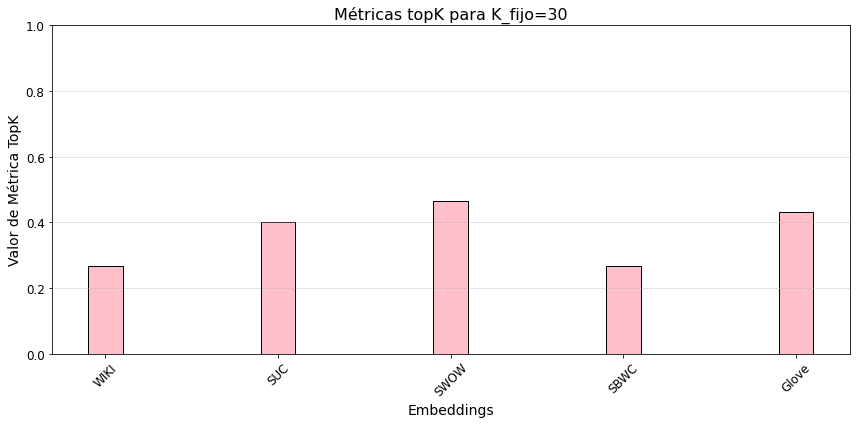

In [ ]:
# datos para el valor de K fijo
data_fijo = topK_metricas_fijo

# Nombres de embeddings
lista_de_Nombres = ["WIKI", "SUC", "SWOW", "SBWC", "Glove"]

# numero de embeddings
num_embeddings = len(lista_de_Nombres)

width = 0.2

# Crear la figura para los datos del valor de K fijo
fig, ax = plt.subplots(figsize=(12, 6))

# valores de x para cada barra
x = np.arange(num_embeddings)

bar = ax.bar(x, data_fijo, width, color='pink', edgecolor='black')

# Etiquetas 
ax.set_xlabel('Embeddings', fontsize=14)
ax.set_ylabel('Valor de Métrica TopK', fontsize=14)
ax.set_title(f'Métricas topK para K_fijo={K_fijo}', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(lista_de_Nombres, rotation=45, fontsize=12)

# Limitar el eje y entre 0 y 1
ax.set_ylim([0, 1])

ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()
